In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
import timeit

def get_edge_image(img):
    kernel_x = np.array([[-1, 0, 1],
                         [-1, 0, 1],
                         [-1, 0, 1]])
    kernel_y = np.array([[-1, -1, -1],
                         [0, 0, 0],
                         [1, 1, 1]])
    img_x = convolve2d(img, kernel_x, mode='same', boundary='fill', fillvalue=0)
    img_y = convolve2d(img, kernel_y, mode='same', boundary='fill', fillvalue=0)

    img_out = np.sqrt(img_x * img_x + img_y*img_y)
    return img_out

def response_convolution(img_large,img_template):
    img_template = np.flipud(np.fliplr(img_template))
    img_response = convolve2d(img_large, img_template, mode='same', boundary='fill', fillvalue=0)
    return img_response
    
def response_fft(img_large,img_template):

    (h,w) = img_large.shape
    img_large = pad_to(img_large, h*2, w*2)
    img_template = pad_to(img_template, h*2, w*2)
    
    template_fft = np.fft.fft2(img_template)
    image_fft    = np.fft.fft2(img_large)
    
    # Perform element-wise multiplication
    #multiplying by complex conjugate returns magnitude 
    correlation_result_fft = image_fft * np.conj(template_fft)
    
    # Perform inverse FFT to get correlation result in spatial domain
    correlation_result = np.fft.ifft2(correlation_result_fft)
    correlation_result = np.fft.fftshift(correlation_result).real

    return   crop_center(correlation_result,w,h)
    
def pad_to(array, xx, yy):

    h = array.shape[0]
    w = array.shape[1]

    a = (xx - h) // 2
    aa = xx - a - h

    b = (yy - w) // 2
    bb = yy - b - w

    return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')

def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]


In [33]:
import os
#os.chdir(r"C:\github\template")

img_large = cv2.imread('cameraman.jpg')

img_template = cv2.imread('head.jpg')



# Convert images to grayscale
img_template = cv2.cvtColor(img_template, cv2.COLOR_BGR2GRAY) 
img_large = cv2.cvtColor(img_large, cv2.COLOR_BGR2GRAY)
img_large = pad_to(img_large, 512, 512)
print(img_large.shape)

img_large = get_edge_image(img_large)
img_template = get_edge_image(img_template)

(512, 512)


In [34]:
# Perform template matching

img_response = response_convolution(img_large,img_template)

#img_response = response_fft(img_large,img_template)


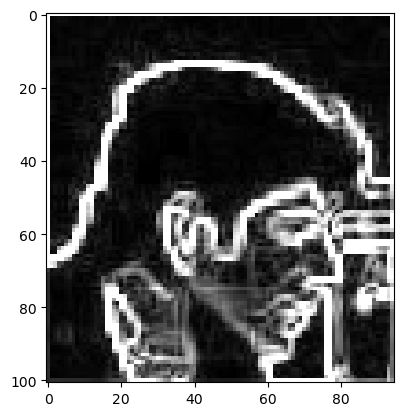

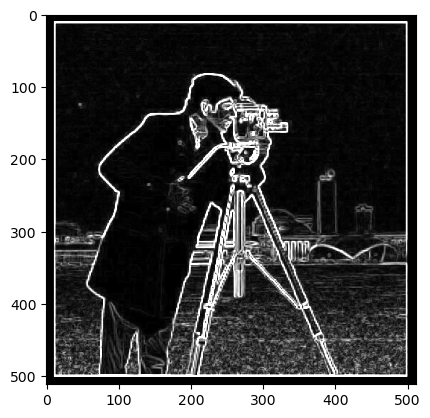

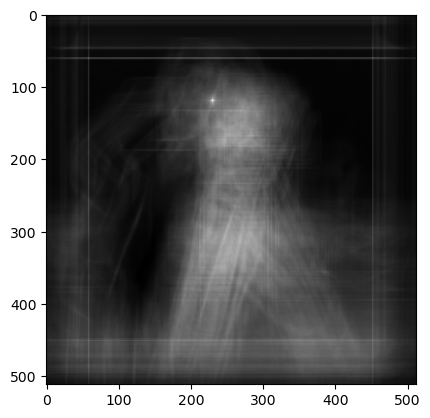

In [35]:
plt.imshow(img_template, cmap=plt.cm.gray, vmin=0, vmax=255)
plt.figure()
plt.imshow(img_large, cmap=plt.cm.gray, vmin=0, vmax=255)
plt.figure()
plt.imshow(img_response, cmap=plt.cm.gray)
plt.show()

In [36]:
img_response = response_fft(img_large,img_template)


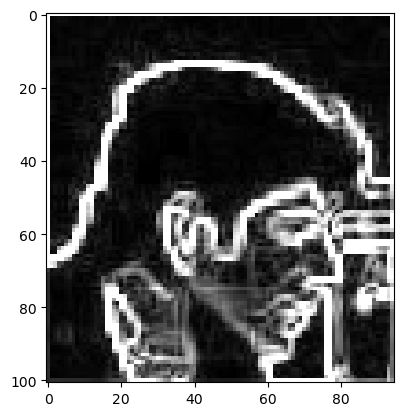

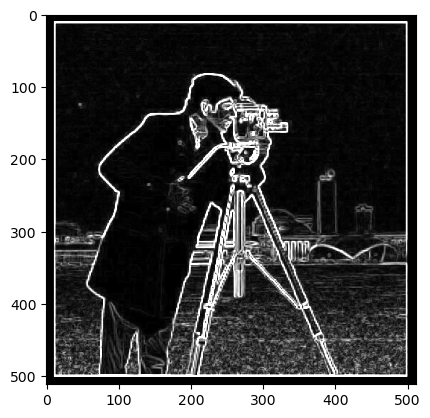

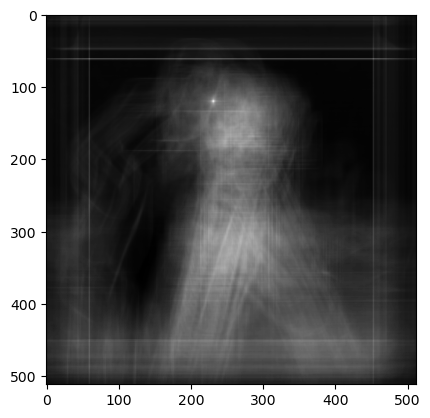

In [37]:
plt.imshow(img_template, cmap=plt.cm.gray, vmin=0, vmax=255)
plt.figure()
plt.imshow(img_large, cmap=plt.cm.gray, vmin=0, vmax=255)
plt.figure()
plt.imshow(img_response, cmap=plt.cm.gray)


plt.show()